# Performance: numpy vs. event-based packages
*numpy vs. PyRX vs. Faust*

## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import rx
from rx import operators as ops
import faust

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100
plt.rcParams['font.family'] = 'monospace'
plt.style.use('seaborn')

## Moving Average

In [2]:
avg_window = 100
data = np.random.normal(0, 1, size=50000)
data

array([-1.58803393,  1.93041777,  1.45836563,  0.22372859,  0.73685409,  0.32136115,  0.7002843 ,  0.38572437, -0.602963  , -0.6011543 ,  1.35011367,  0.46556494,  0.12692944, -1.85051964,  0.76843474,  0.30736873, -2.33319172, -1.30265465,  0.18877227, -0.30290652,  0.58175489,  0.80944634,  0.19701278,  0.59852322, -0.5803318 ,  0.6690119 ,  0.46912861, -1.30121011, -0.18484739, -1.35105641, ..., -1.4502047 ,  0.66834471, -1.15150057,  0.17135772, -0.37680679,  0.89733201, -1.05414048, -0.98379991,  0.68973862,  2.0747479 , -1.1435054 ,  0.84943906, -1.00411848,  1.15190816,  0.9943296 ,  1.78466407, -0.34927363,  0.93561575, -0.96687273,  1.63372751, -0.47901713,  0.6811047 ,  0.53702279, -1.65172152, -0.11050493, -0.12809902, -0.93143254,  0.25603089, -0.38555527, -0.21326364])

### Numpy

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
%%time
metric = np.mean(rolling_window(data, avg_window), 1)
print(len(metric), metric[:5])

49901 [-0.09452825 -0.06647452 -0.08062741 -0.10318734 -0.09665021]
CPU times: user 2.52 ms, sys: 0 ns, total: 2.52 ms
Wall time: 2.36 ms


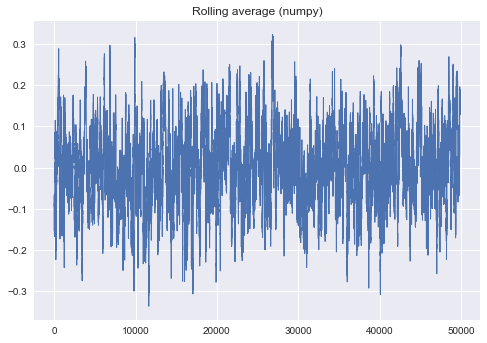

In [5]:
plt.plot(metric, lw=1)
plt.title('Rolling average (numpy)')
_=_

### PyRX

In [6]:
source = rx.from_list(data)

#### Method 1: buffer

In [7]:
%%time
metric = []
source.pipe(
    ops.buffer_with_count(count=avg_window, skip=1), 
    ops.map(lambda x: sum(x)/len(x)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

50000 [-0.09452824826136526, -0.06647452324461159, -0.08062740921213712, -0.10318733924117068, -0.09665021436478692]
CPU times: user 9.5 s, sys: 0 ns, total: 9.5 s
Wall time: 9.5 s


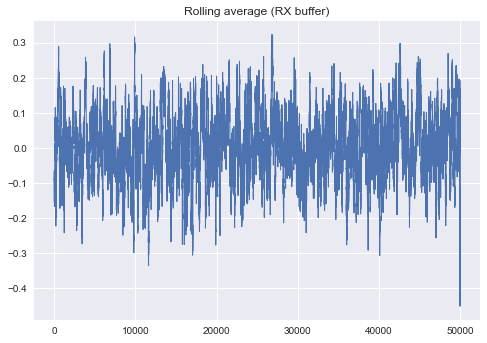

In [8]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX buffer)')
_=_

#### Method 2: scan

In [9]:
%%time
metric = []
source.pipe(
    ops.scan(lambda acc, x: (acc + [x])[-avg_window:], []),
#     ops.skip(1),
    ops.map(lambda x: sum(x)/len(x)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

50000 [-1.588033934011456, 0.17119191565928316, 0.6002498211683501, 0.5061195139075272, 0.5522664294550297]
CPU times: user 276 ms, sys: 11.5 ms, total: 288 ms
Wall time: 286 ms


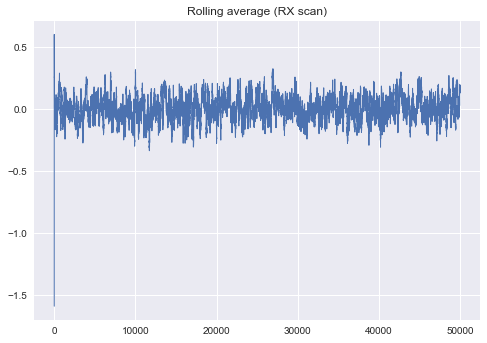

In [10]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX scan)')
_=_

#### Method 3: scan (optimized)

In [11]:
%%time
metric = []
source.pipe(
    ops.scan(lambda acc, x: acc + x, 0), 
    ops.scan(lambda acc, x: (acc + [x])[-avg_window-1:], []),
    ops.skip(1),
    ops.map(lambda x: (x[-1] - x[0])/(len(x)-1)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

49999 [1.9304177653300223, 1.6943916987582532, 1.204170663213855, 1.087341520321651, 0.9341454469448827]
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 139 ms


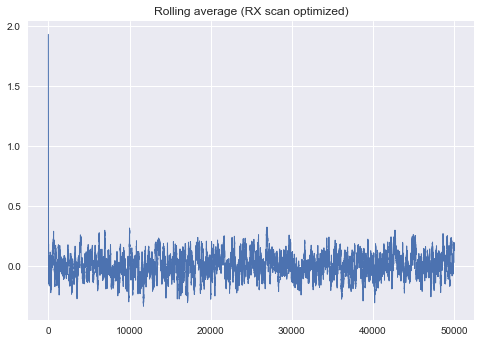

In [12]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX scan optimized)')
_=_

#### Method 4: custom operator

In [13]:
def custom_moving_avg(window: int = None):
    def _foo(source):
        tail = []
        avg = np.nan
        def subscribe(observer, scheduler = None):
            def on_next(value):
                nonlocal tail
                nonlocal avg
                tail.append(value)
                n = len(tail)
                assert n <= window + 1
                if n == 1:
                    avg = tail[-1]
                elif n <= avg_window:
                    avg = (avg * (n-1) + value) / n
                else:
                    first = tail.pop(0)
                    n = avg_window
                    avg = avg + (value - first) / n
                observer.on_next(avg)

            return source.subscribe(
                on_next,
                observer.on_error,
                observer.on_completed,
                scheduler)
        return rx.create(subscribe)
    return _foo

In [14]:
%%time
metric = []
source.pipe(
   custom_moving_avg(window=avg_window),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

50000 [-1.588033934011456, 0.17119191565928316, 0.6002498211683501, 0.5061195139075272, 0.5522664294550297]
CPU times: user 53 ms, sys: 51 µs, total: 53.1 ms
Wall time: 52.5 ms


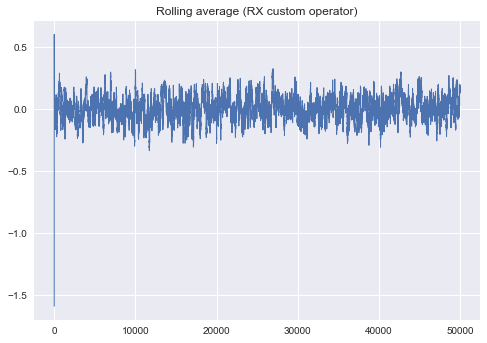

In [15]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX custom operator)')
_=_

#### Method 5: window

In [16]:
# TODO

# %%time
# metric = []
# source.pipe(
#     ops.window_with_count(count=avg_window, skip=1),
# #     ops.skip(1),
#     ops.flat_map(),
#     ops.average(),
# ).subscribe(
#     on_next = lambda i: metric.append(i)
# )
# print(len(metric), metric[:5])

In [17]:
# plt.plot(metric, lw=1)
# plt.title('Rolling average (RX scan)')
# _=_

## Faust

In [18]:
# TODO